In [21]:
import math
import sys
sys.path.append('../')
from fcts import array_in_nd_array, remove_space, r2pcorr,struc2mol
import numpy as np
import pandas as pd
import darkchem
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.linear_model import LinearRegression
from rdkit import Chem
from rdkit.Chem.Draw import MolToImage
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
import statistics

In [2]:
# Load model
model = darkchem.utils.load_model('../../../DarKnight_File/Final Trained DarkChem Network Weights/N7b_[M+H]/') 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [3]:
# load training set
x = np.load('../../../DarKnight_File/Training Data - Molecules/combined_[M+H]_smiles.npy')

In [4]:
# Define a fuction that can check the existance of our input molecules
def array_in_nd_array(test, array):
    """
    Checks whether or not a test 1D array is contained within a full N-D array.
    Returns True if the test array is equal to any of the dimensions of the N-D array.
    Returns False if the test array does not match any dimension of the N-D array.
    """
    return any(np.array_equal(x, test) for x in array)

In [5]:
# Define a fuction that transfer input molecules into vectors
def smi_vec_verify(dic):
    
    """Takes a dictionary with reactants and products.
    Creates vectorized representations and appends to dictionary
    as 'rvec' and 'pvec'.
    Checks that both vector types are contained within the loaded
    dataset x.
    
    """
    assert type(dic) == dict, 'Input must be a dictionary'
    assert len(dic) == 2, 'Input dictionary must contain 2 items (reactants, products)'
    
    dic['rvec'] = [darkchem.utils.struct2vec(reactant).astype(np.int16) for reactant in dic['reactants']]
    dic['pvec'] = [darkchem.utils.struct2vec(product).astype(np.int16) for product in dic['products']]
    
    is_in_testset = [[array_in_nd_array(item, x) for item in key] for key in dic.values()]
    
    print(f"Is each reactant contained in the DarkChem training set?: {is_in_testset[2]}")
    print(f"Is each product contained in the DarkChem training set?: {is_in_testset[3]}")
    
    return dic

In [6]:
# Define a function that generate the latent space and calulate the average reaction vector
def vec_latent_rxn_vector(dic):
    
    """Takes a dictionary with reaction vectors and product vectors.
    Converts vectorized representations to latent space vector
    representations and appends to dictionary as 'rlat' and 'plat'.
    
    Calculates reaction vector (subtraction of reactant latent space
    vector from product latent space vector.
    
    Displays Pearson correlation matrix for all reaction vectors.
    
    Averages all reaction vectors and returns dic, avgvec.
    
    """
    dic['rlat'] = model.encoder.predict(np.array(dic['rvec']))
    dic['plat'] = model.encoder.predict(np.array(dic['pvec']))
    
    dic['rxnvector'] = [dic['plat'][i] - dic['rlat'][i] for i in range(len(dic['plat']))]
    
    print(pd.DataFrame(np.corrcoef(dic['rxnvector']).view(type=np.matrix)))
    
    avgvec = np.array(dic['rxnvector']).sum(axis=0) / len(dic['rxnvector'])
    
    return dic, avgvec

In [7]:
# Define a function that apply the reaction vector to an input molecule
def apply_rxn_vector(smistr, rxnvec, nummols=10, savefilename=False):
    
    """Takes a SMILES string representation for a molecule.
    Adds input vector (e.g. avgvec output from vec_latent_rxn_vector)
    and shows chemical structures for the top 10 highest-probability
    product predictions (can be altered with nummols)
    
    """
    testvec = darkchem.utils.struct2vec(smistr).astype(np.int16)
    array_in_nd_array(testvec, x)
    
    testlat = model.encoder.predict(np.array(testvec.reshape(-1,100)))
    
    testprod = testlat + rxnvec
    testpvec = model.decoder.predict(testprod)
    testprods = darkchem.utils.beamsearch(testpvec, k=nummols)
    
    predictions = {}
    
    predictions['predprod'] = [darkchem.utils.vec2struct(i) for i in testprods[0]]
    predictions['predprodmol'] = [Chem.MolFromSmiles(predictions['predprod'][i])
                                  for i in range(len(predictions['predprod']))]
    
    if type(savefilename) == str:
        img = Chem.Draw.MolsToGridImage(predictions['predprodmol'],
                                        molsPerRow=5, subImgSize=(200, 200))
        img.save(f'./{savefilename}.png')
    
    return Chem.Draw.MolsToGridImage(predictions['predprodmol'],
                                     molsPerRow=5, subImgSize=(200, 200))

In [8]:
# load training data of Alcohol_Dehydration
data = pd.read_excel('../../database/Alcohol_Dehydration.xlsx')

#remove the redundant space in the smiles string
data = remove_space(data)

..\fcts.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['Reactants'][i] = data['Reactants'][i].replace(' ','')
..\fcts.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['Products'][i] = data['Products'][i].replace(' ','')


In [9]:
# Transform reactants and products into dictionary
red = {'reactants': data['Reactants'],
       'products': data['Products']}

In [10]:
# Transform the molecules above into vector and check the existance in the training set
red = smi_vec_verify(red)

Is each reactant contained in the DarkChem training set?: [False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True]
Is each product contained in the DarkChem training set?: [True, True, True, True, True, False, True, True, True, True, True, True, False, True, True, True, False]


In [11]:
# Generate the latent space
red, redvec = vec_latent_rxn_vector(red)

          0         1         2         3         4         5         6   \
0   1.000000  0.576913  0.502995  0.412270  0.345671  0.330784  0.343978   
1   0.576913  1.000000  0.916099  0.672300  0.863099  0.778659  0.765092   
2   0.502995  0.916099  1.000000  0.860326  0.822517  0.933915  0.909939   
3   0.412270  0.672300  0.860326  1.000000  0.574867  0.826805  0.828623   
4   0.345671  0.863099  0.822517  0.574867  1.000000  0.856135  0.790154   
5   0.330784  0.778659  0.933915  0.826805  0.856135  1.000000  0.933646   
6   0.343978  0.765092  0.909939  0.828623  0.790154  0.933646  1.000000   
7   0.358882  0.396801  0.327827  0.115406  0.556524  0.382607  0.500829   
8   0.269018  0.482008  0.680800  0.885835  0.466856  0.695865  0.741895   
9   0.478637  0.659520  0.681790  0.549435  0.598615  0.627557  0.784550   
10  0.276164  0.534664  0.801830  0.825773  0.494940  0.848436  0.813047   
11  0.313349  0.605863  0.789417  0.799214  0.544088  0.779152  0.932597   
12  0.276825

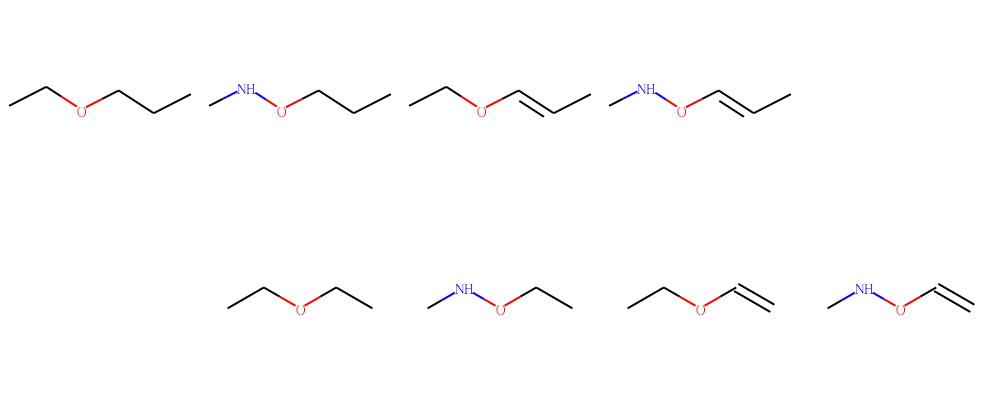

In [14]:
# Predict a certain molecule
ethanol = 'CCO'
apply_rxn_vector(ethanol, redvec, savefilename='Alcohol_Dehydration')

In [15]:
# Put those vectors into DataFrame
rct = pd.DataFrame(red['rlat'])
prod = pd.DataFrame(red['plat'])

In [22]:
# Calcualte the lengh of each reaction path
s = 0
d = []
for i in range(16):
    for j in range(128):
        s += (rct.loc[i][j] - prod.loc[i][j])**2
    ds = np.sqrt(s)
    d.append(ds)
    
# Calculate the average length of the Alcohol Dehydration reaction path
sum = 0
for num in d:
    sum = sum +num
    average = sum / len(d)

# Calculate the std length of the Alcohol Dehydration reaction path
std = statistics.stdev(d)

print('The length of each reaction path =', d)
print('The average length of the Alcohol Dehydration reaction path =', average)
print('The std length of the Alcohol Dehydration reaction path =', std)

The length of each reaction path = [1.2697196729769782, 2.0711251690655565, 3.2030449194331205, 4.188647736067467, 4.338059721705004, 4.727327451261856, 5.503999815523266, 5.964363103725846, 6.431759824233994, 7.197952031081168, 7.2588215953126625, 7.510601957690438, 8.013903867508434, 8.541692365609348, 8.943667330839345, 9.670312838410844]
The average length of the Alcohol Dehydration reaction path = 5.927187462527833
The std length of the Alcohol Dehydration reaction path = 2.4711698017476884


In [23]:
# Calculate the dot product of each reaction
s2 = 0
d2= []
for i in range(16):
    for j in range(128):
        s2 += (rct.loc[i][j] * prod.loc[i][j])
    #ds = np.sqrt(s)
    d2.append(s2)


# Calculate the product of each reactant and product
s3 = 0
s4 = 0
d3= []
for i in range(16):
    for j in range(128):
        s3 += (rct.loc[i][j])**2
        s4 += (prod.loc[i][j])**2
    dd = np.sqrt(s3)
    dx = np.sqrt(s4)
    xx = dd*dx
    d3.append(xx)

# Insert the formula of Cosine theorem
a = []
for i in range(16):
    cos = d2[i]/d3[i]  #this is the value of cos(sita)
    angle = math.acos(cos)  #this is the value of sita
    a.append(angle)

# Calculate the average angle of the Alcohol Dehydration reaction path    
sum = 0
for num in a:
    sum = sum +num
    average = sum / len(a)
    
# Calculate the std angle of the Alcohol Dehydration reaction path
std = statistics.stdev(a)

print('The angle between the vectors of reactants and products of each reactions =', a)
print('The average angle of the Alcohol Dehydration reaction =', average)
print('The std angle of the Alcohol Dehydration reaction path =', std)

The angle between the vectors of reactants and products of each reactions = [0.1144502956232191, 0.1255873731103671, 0.15121790456675654, 0.16808341022561898, 0.15809117562422714, 0.15485472363839922, 0.16558959533646433, 0.17383979500717847, 0.17494206948400312, 0.18553605104141543, 0.17959210696511269, 0.17752169415927355, 0.1814194037937638, 0.19100874779248944, 0.19425072137410668, 0.20451620025236653]
The average angle of the Alcohol Dehydration reaction = 0.16878132924967262
The std angle of the Alcohol Dehydration reaction path = 0.02389133361586162


#### Alcohol Dehydration
| Index |    1|    2|    3|    4|    5|    6|    7|    8|    9|   10|   11|   12|   13|   14|   15|   16|  Avg|  Std|
|-------|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
| Length|1.269|2.071|3.203|4.188|4.338|4.727|5.504|5.964|6.431|7.197|7.258|7.510|8.014|8.542|8.944|9.670|5.927|2.471|
| Angle |0.114|0.125|0.151|0.168|0.158|0.154|0.165|0.173|0.174|0.185|0.179|0.178|0.181|0.191|0.194|0.205|0.169|0.024|